In [ ]:
import numpy as np
import pywt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import os
import torch.nn.functional as FF
import shutil  # For deleting the folder
import scipy
import tensorflow as tf
import matplotlib.cm as cm
import scipy.ndimage

from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from skimage import io
from skimage import metrics
from skimage.color import rgb2gray
from skimage.transform import resize

device = ("cuda" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path where you want to copy the Dataset1 folder in Colab
colab_folder = "/content/Dataset1"

# Copy the Dataset1 folder from Google Drive to Colab
!cp -r "/content/drive/MyDrive/Dataset1" "$colab_folder"

# Check if the copy was successful
!ls "$colab_folder"

Mounted at /content/drive
Test  Train  Validation


In [ ]:
"""
module.
Class
-----------
MyDataset : manages loading data to be fed to the first layer of unrolled architecture.
"""

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, folder,initial_x0, need_names):
        super(MyDataset, self).__init__()
        self.folder_Gr = os.path.join(folder, "Groundtruth")
        self.folder_Dr = os.path.join(folder, "Degraded")

        self.file_names_Gr = os.listdir(self.folder_Gr)
        self.file_names_Dr = os.listdir(self.folder_Dr)
        if self.file_names_Gr.count('.ipynb_checkpoints') !=0:
            self.file_names_Gr.remove('.ipynb_checkpoints')

        self.file_list_Gr = [os.path.join(self.folder_Gr, i) for i in self.file_names_Gr if not i.startswith('.')]
        self.file_list_Dr = [os.path.join(self.folder_Dr, i) for i in self.file_names_Dr if not i.startswith('.')]
        self.need_names = need_names
        self.initial_x0=initial_x0

    def __getitem__(self, index):
        #print(index)
        index = index%2000
        X_true = np.load(self.file_list_Gr[index], allow_pickle=True)
        Degraded_path = (self.file_list_Gr[index].replace('Groundtruth', 'Degraded')).replace('Gr_', 'Dr_')
        X_degraded = np.load(Degraded_path, allow_pickle=True)
        if self.need_names == 'no':
            return X_true, X_degraded
        if self.need_names == "yes":
            name=os.path.splitext(self.file_names_Gr[index])[0]
            return name, X_true, X_degraded

    def __len__(self):
        return len(self.file_list_Gr)

In [ ]:
def soft_thresh(w, mu):
    w -= np.clip(w, -mu, mu)
    return w


def Loss_fun(A, B):
    return F.mse_loss(A, B)

#def Loss_fun(A, B):
#    return nn.MSELoss(A,B)

def activation_primal(u, tau, factor=1.): #soft- thresh in torch
    zer = torch.zeros_like(u)
    return torch.sign(u) * torch.maximum(zer, torch.abs(u) - tau)
def activation_primal_wavelet(u, tau, factor=1.):
    # Move tensor to CPU
    u_cpu = u.cpu()

    # Apply Daubechies wavelet transformation
    wavelet = 'db4'  # You can choose the appropriate Daubechies wavelet
    coeffs = pywt.wavedec(u_cpu.detach().numpy(), wavelet)

    # Thresholding (soft-thresholding in this case)
    threshold = tau.item() * factor
    coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

    # Inverse wavelet transform
    u_wavelet = torch.from_numpy(pywt.waverec(coeffs_thresholded, wavelet)).to(u.device)

    return u_wavelet

In [ ]:
# Unrolling

# Create the stepsize architecture in pytorch

R = nn.ReLU()
class stepsize_arch(torch.nn.Module): # Architecture of learnable parameters
    def __init__(self):
        super(stepsize_arch, self).__init__()
        self.tau = nn.Parameter(torch.DoubleTensor([10]).cuda(), requires_grad=True)
        self.sigma = nn.Parameter(torch.DoubleTensor([0.01]).cuda(), requires_grad=True)
        self.rho = nn.Parameter(torch.DoubleTensor([1]).cuda(), requires_grad=True)
        # 10, 0,01 and 1 are the initializations of the parameters

    def forward(self):
        tau = R(self.tau)
        sigma = R(self.sigma)
        rho = R(self.rho) # Non-negativity constraints for all of the parameters
        return (tau, sigma, rho)

class layer(torch.nn.Module):
    def __init__(self):
        super(layer, self).__init__()
        self.architecture = stepsize_arch()

    def forward(self, H, p, p_old, d, d_old, x, x_old, y): # This defines one layer of the neural architecture
        tau, sigma, rho = self.architecture()
        x = x.to(device)
        x_old = x_old.to(device)
        p = p.to(device)
        p_old = p_old.to(device)
        H = H.to(device)
        y = y.to(device)
        d_old = d
        d = d + sigma * (torch.t(torch.mm(H, torch.t(x + p - p_old))) - y)
        bd = - tau * torch.t(torch.mm(torch.t(H), torch.t(d)))
        x_old = x
        x = activation_primal(p + bd, 0.01*tau)
        bp = torch.t(torch.mm(H, torch.t(x))) - y
        bp = torch.t(torch.mm(torch.t(H), torch.t(bp)))
        p_old = p
        p = x - rho * bp
        return p, p_old, d, d_old, x, x_old


class PD_model(torch.nn.Module):
    def __init__(self, num_layers, H):
        super(PD_model, self).__init__()
        self.Layers = nn.ModuleList()
        for i in range(num_layers):
            self.Layers.append(layer())

    def forward(self, H, p0, p0_old, d0, d0_old, x0, x0_old, y, x_true): # This is the whole NN, with many layers as num_layers
        for i, l in enumerate(self.Layers):
            # mse = Loss_fun(p0, x_true)
            p_update, p_old_update, d_update, d_old_update, x_update, x_old_update = self.Layers[i](H, p0, p0_old, d0, d0_old, x0, x0_old, y)
            p0 = p_update
            p0_old = p_old_update
            x0 = x_update
            x0_old = x_old_update
            d0 = d_update
            d0_old = d_old_update
        return p_update, d_update


In [ ]:
class Network(nn.Module):
    def __init__(self, Initialization, train_conditions, paths):
        super(Network,self).__init__()
        self.number_layers, self.H, self.initial_x0 = Initialization
        self.number_epochs, self.lr, self.train_batch_size, self.val_batch_size, self.test_batch_size = train_conditions
        self.path_train, self.path_validation, self.path_test, self.path_save_model = paths
        self.model = PD_model(self.number_layers, self.H).cuda()
        self.dtype = torch.cuda.DoubleTensor

    def CreateLoader(self, need_names): # data loader
        train_data = MyDataset(self.path_train, self.initial_x0, need_names)
        self.train_loader = DataLoader(train_data, batch_size=self.train_batch_size, shuffle=True)
        val_data = MyDataset(self.path_validation,self.initial_x0, need_names)
        self.val_loader = DataLoader(val_data, batch_size=self.val_batch_size, shuffle=True)
        test_data = MyDataset(self.path_test, self.initial_x0, need_names)
        self.test_loader = DataLoader(test_data, batch_size=self.test_batch_size, shuffle=True)
        #print(self.test_loader)
########################################################

    def train(self, number_try, need_names, path_model=None):
        epoc = 0
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        if not os.path.exists(os.path.join(self.path_save_model,'Trained_Model'+'_'+str(number_try))):
            os.makedirs(os.path.join(self.path_save_model,'Trained_Model'+'_'+str(number_try)))
            file_object = open(os.path.join(self.path_save_model,'Trained_Model'+'_'+str(number_try)) + "/readme.txt", "a")
            file_object.writelines([    "Optimizer: " + str(optimizer) + '\n',
                                        "learning_rate:"+ str(self.lr)+ '\n',
                                        "Number layers: " + str(self.number_layers) + '\n',
                                         "batch_val_size: " + str(self.val_batch_size) + '\n',
                                        "batch_train_size: " + str(self.train_batch_size) + '\n',
                                       ])
            file_object.close()

        self.CreateLoader(need_names=need_names)

        loss_epochs = []
        val_loss_epochs = []

        for epoch in range(self.number_epochs):
            # print("epoc is", epoc)
            print("epoch is", epoch)
            if (epoch + epoc) == 0 :
                self.model.eval()
            if (epoch + epoc) > 0 :
                self.model.train()
            running_loss = 0.0
            for i, minibatch in enumerate(self.train_loader, 0):
                #print(i)
                if need_names == "yes":
                    [name, x_true, x_degraded] = minibatch

                if need_names == "no":
                    [x_true, x_degraded] = minibatch
                #sel = random.permutation(d)
                # sel = sel[0 : self.train_batch_size]   # indices of the nonzero elements of xsharp
                # for iter in range(self.train_batch_size):


                x_true = x_true.type(self.dtype)
                x_degraded = x_degraded.type(self.dtype)
                # if epoch == 0:
                #     x_true_cpu0 = x_true[0, :, :].cpu()
                #     x_true_cpu0 = np.reshape(x_true_cpu0, [28, 28])
                #     x_degraded_cpu0 = x_degraded[0, :, :].cpu()
                #     x_degraded_cpu0 = np.reshape(x_degraded_cpu0, [28, 28])
                #     #x_pred_cpu = x_pred.cpu().detach().numpy()
                #     #x_pred_cpu = np.reshape(x_pred_cpu, [28, 28])
                #     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                #     axs[0].imshow(x_true_cpu0, cmap='gray',vmin=0, vmax=1)
                #     axs[0].set_title('Original')
                #     axs[1].imshow(x_degraded_cpu0, cmap='gray',vmin=0, vmax=1)
                #     axs[1].set_title('Blurred, noisy')
                # print("loss is", Loss_fun(x_true, x_degraded).detach())
                x0 = torch.zeros((self.train_batch_size, x_true.size()[1] * x_true.size()[2])).type(self.dtype)
                x0_d = torch.zeros((self.train_batch_size, x_degraded.size()[1] * x_degraded.size()[2])).type(self.dtype)
                if (epoch + epoc) == 0:
                    p0 = x0
                    p0_old = x0
                    z0 = x0
                    z0_old = x0
                    d0 = x0_d
                    d0_old = x0_d
                    y = x_degraded
                    y_cpu = y.cpu()

                    y = torch.reshape(y_cpu, [y_cpu.size()[0], y_cpu.size()[1] * y_cpu.size()[2]])
                    #print(y.size())
                    x_pred, x_pred1 = self.model(self.H, p0, p0_old, d0, d0_old, z0, z0_old, y, x_true)
                    #print(x_pred.size())
                    x_true_cpu = x_true.cpu()
                    x_true = torch.reshape(x_true_cpu, [x_true_cpu.size()[0], x_true_cpu.size()[1] * x_true_cpu.size()[2]])
                    #print(x_true.size())
                    x_pred = x_pred.to(device)
                    x_true = x_true.to(device)
                    loss = Loss_fun(x_pred, x_true).detach()
                    running_loss += loss.item()

                if (epoch + epoc) > 0:
                    optimizer.zero_grad()
                    p0 = x0
                    p0_old = x0
                    z0 = x0
                    z0_old = x0
                    d0 = x0_d
                    d0_old = x0_d
                    y = x_degraded
                    y_cpu = y.cpu()
                    y = torch.reshape(y_cpu, [y_cpu.size()[0], y_cpu.size()[1] * y_cpu.size()[2]])
                    x_pred, x_pred1 = self.model(self.H, p0, p0_old, d0, d0_old, z0, z0_old, y, x_true)
                    x_true_cpu = x_true.cpu()
                    x_true = torch.reshape(x_true_cpu, [x_true_cpu.size()[0], x_true_cpu.size()[1] * x_true_cpu.size()[2]])
                    x_pred = x_pred.to(device)
                    x_true = x_true.to(device)
                    # print(Loss_fun(x_true.cpu(), y.cpu()).detach())
                    loss = Loss_fun(x_pred, x_true)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    torch.autograd.set_detect_anomaly(True)
            loss_epochs.append(running_loss / (len(self.train_loader)))
            print("train loss for epoch", epoch + epoc , "is", running_loss / (len(self.train_loader)))

            # saving model here
            torch.save({
                    'epoch': epoch + epoc ,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss, },
                    os.path.join(self.path_save_model,'Trained_Model'+'_'+str(number_try))+ '/epoch'+ str(epoch + epoc ))

            #Evaluation on validation set
            self.model.eval()
            with torch.no_grad():
                loss_current_val = 0
                for minibatch in self.val_loader:
                    if need_names == "yes":
                        [name, x_true, x_degraded] = minibatch
                    if need_names == "no":
                        [x_true, x_degraded] = minibatch

                    x_true = x_true.type(self.dtype)
                    x_degraded = x_degraded.type(self.dtype)
                    x0 = torch.zeros((self.train_batch_size, x_true.size()[1] * x_true.size()[2])).type(self.dtype)
                    x0_d = torch.zeros((self.train_batch_size, x_degraded.size()[1] * x_degraded.size()[2])).type(self.dtype)

                    p0 = x0
                    p0_old = x0
                    z0 = x0
                    z0_old = x0
                    d0 = x0_d
                    d0_old = x0_d
                    y = x_degraded
                    y_cpu = y.cpu()
                    y = torch.reshape(y_cpu, [y_cpu.size()[0], y_cpu.size()[1] * y_cpu.size()[2]])
                    x_pred, x_pred1 =self.model(self.H,p0,p0_old,d0,d0_old,z0,z0_old,y,x_true)
                    x_true_cpu = x_true.cpu()
                    x_true = torch.reshape(x_true_cpu, [x_true_cpu.size()[0], x_true_cpu.size()[1] * x_true_cpu.size()[2]])
                    x_pred = x_pred.to(device)
                    x_true = x_true.to(device)
                    loss_val = Loss_fun(x_pred, x_true)
                    loss_current_val += torch.Tensor.item(loss_val)
                val_loss_epochs.append(loss_current_val / (len(self.val_loader)))
                print("val loss for epoch", epoch + epoc , "is", loss_current_val / (len(self.val_loader)))
                #Saving training evolution in readme file
                file_object = open(
                    os.path.join(self.path_save_model, 'Trained_Model'  + '_' + str(number_try)) + "/readme.txt",
                        "a")
                file_object.writelines([ "Train loss for epoch "+ str(epoch + epoc)+ "is: "+ str( running_loss / (len(self.train_loader)))+'\n',
                                            "Val loss for epoch" +str(epoch + epoc ) +"is: "+ str(loss_current_val / (len(self.val_loader)))+ '\n'
                                           ])
                file_object.close()
                plt.plot(loss_epochs,color='black', linestyle='dashed', linewidth=1)
                plt.plot(val_loss_epochs,color='blue' ,linestyle='dashed', linewidth=1)
                axes = plt.gca()
                axes.set_xlabel('Epochs')
                axes.set_ylabel('Average MSE loss')
                plt.legend(["Training loss", "Validation loss"])
                plt.savefig(os.path.join(self.path_save_model, 'Trained_Model'  + '_' + str(number_try))+'/Trained_Model'  + str(number_try)+"Training_curves.png")
        return

    def test(self, path_set=None, path_model=None, need_names="no", path_signal=None, path_save_estimate=False):
        checkpoint = torch.load(path_model, map_location='cuda:0')
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()

        if path_signal is not None :

            name = os.path.split(path_signal)[1]
            x_true = torch.unsqueeze(torch.tensor(np.load(path_signal, allow_pickle=True)),0)
            x_degraded = torch.unsqueeze(torch.tensor(np.load(path_signal.replace('Groundtruth', 'Degraded').replace('_Gr_','_Dr_'), allow_pickle=True)), 0)
            x_true = x_true.type(self.dtype)
            x_degraded = x_degraded.type(self.dtype)
            x_0 = torch.zeros((1, x_true.size()[1] * x_true.size()[2])).type(self.dtype)
            x0_d = torch.zeros((1, x_true.size()[1] * x_true.size()[2])).type(self.dtype)

            t0 = time.time()
            p0 = x_0
            p0_old = x_0
            z0 = x_0
            z0_old = x_0
            d0 = x0_d
            d0_old = x0_d
            y = x_degraded
            y_cpu = y.cpu()
            y = torch.reshape(y_cpu, [y_cpu.size()[0], y_cpu.size()[1] * y_cpu.size()[2]])
            x_pred, x_pred1 =self.model(self.H, p0, p0_old, d0, d0_old, z0, z0_old, y, x_true)
            t1 = time.time()
            x_true_cpu = x_true.cpu()
            x_true = torch.reshape(x_true_cpu, [x_true_cpu.size()[0], x_true_cpu.size()[1] * x_true_cpu.size()[2]])
            loss = Loss_fun(x_pred, x_true).detach()
            print("loss is:", loss)
            print("Execution time is",t1 - t0)
            return x_pred.detach()
        else:
            self.CreateLoader(need_names)
            total_loss = 0
            total_time = 0
            high_MSE = 0
            i = 0
            MSE_list = []

            for minibatch in self.test_loader:
                if need_names == "yes":
                    [name, x_true, x_degraded] = minibatch
                    name = name[0]
                if need_names == "no":
                    [x_true, x_degraded] = minibatch

                x_true = x_true.type(self.dtype)

                #print("shape x_true_else", x_true.size())
                x_degraded = x_degraded.type(self.dtype)

                x0_d = torch.zeros((self.test_batch_size, x_true.size()[1] * x_true.size()[2])).type(self.dtype)
                x_0 = torch.zeros((self.test_batch_size, x_true.size()[1] * x_true.size()[2])).type(self.dtype)
                t0 = time.time()
                p0 = x_0
                p0_old = x_0
                z0 = x_0
                z0_old = x_0
                d0 = x0_d
                d0_old = x0_d
                y = x_degraded
                y_cpu = y.cpu()
                y = torch.reshape(y_cpu, [y_cpu.size()[0], y_cpu.size()[1] * y_cpu.size()[2]])
                #print("size y_else", y.size())
                x_pred, x_pred1 = self.model(self.H, p0, p0_old, d0, d0_old, z0, z0_old, y, x_true) #Primal and dual output of ChPoVe
                #print("shape x_pred_else", x_pred.size())

                t1 = time.time()
                x_true = torch.reshape(x_true, [x_true.size()[0], x_true.size()[1] * x_true.size()[2]])
                #print("shape x_true_else_reshape", x_true.size())
                if i<=10:
                    x_true_cpu = x_true.cpu()
                    x_true_cpu = np.reshape(x_true_cpu, [28, 28])
                    y_cpu = y.cpu()
                    y_cpu = np.reshape(y_cpu, [28, 28])
                    x_pred_cpu = x_pred.cpu().detach().numpy()
                    x_pred_cpu = np.reshape(x_pred_cpu, [28, 28])
                    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
                    axs[0].imshow(x_true_cpu, cmap='gray',vmin=0, vmax=1)
                    axs[0].set_title('Original')
                    axs[1].imshow(y_cpu, cmap='gray',vmin=0, vmax=1)
                    axs[1].set_title('Blurred, noisy')
                    axs[2].imshow(x_pred_cpu, cmap='gray',vmin=0, vmax=1)
                    axs[2].set_title('Unrolling')
                loss = Loss_fun(x_true, x_pred).detach()
                MSE_list.append(loss)

                total_loss += loss
                total_time += t1-t0
                i+=1

            #compute metrics STD
            mse_std = 0
            for l in MSE_list:
                mse_std = mse_std + ((l - total_loss / len(self.test_loader)) ** 2)
            mse_std = torch.sqrt(mse_std/(len(self.test_loader)-1))

            print("Average MSE loss is ", total_loss / len(self.test_loader), "Average execution time is ", total_time / len(self.test_loader))
            print("the standard deviation of MSE loss is", float(mse_std))

            return

epoch is 0
train loss for epoch 0 is 0.007701140308724878
val loss for epoch 0 is 0.007605606516563948
epoch is 1
train loss for epoch 1 is 0.0038860705569341305
val loss for epoch 1 is 0.0035750850514555373
epoch is 2
train loss for epoch 2 is 0.003572327187609944
val loss for epoch 2 is 0.003495603166070181
epoch is 3
train loss for epoch 3 is 0.0035260779419093906
val loss for epoch 3 is 0.00347309492462232
epoch is 4
train loss for epoch 4 is 0.003509414598875311
val loss for epoch 4 is 0.0034554110901062257
epoch is 5
train loss for epoch 5 is 0.0035035331636364283
val loss for epoch 5 is 0.003450619851014831
epoch is 6
train loss for epoch 6 is 0.0034999307758943592
val loss for epoch 6 is 0.0034541376172825705
epoch is 7
train loss for epoch 7 is 0.0035004049619450674
val loss for epoch 7 is 0.003453911564051557
epoch is 8
train loss for epoch 8 is 0.003499589459816966
val loss for epoch 8 is 0.003450075021331349
epoch is 9
train loss for epoch 9 is 0.0034981322456190266
val los

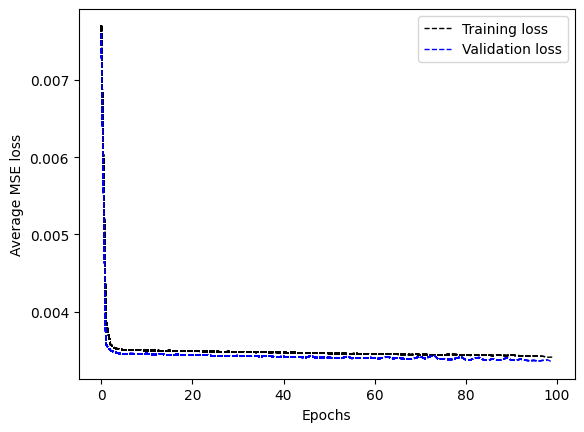

In [ ]:
# Set dataset paths directly
path_train = "/content/Dataset1/Train/"
path_validation = "/content/Dataset1/Validation/"
path_test = "/content/Dataset1/Test/"
path_save_model = "/content/Models/"
paths = [path_train, path_validation, path_test, path_save_model]


N = 28
# Artificial blur
sigma = 1 #too much blur?

# Since N is very small, we can implement the blurring operator as a matrix
K_Mat = np.eye(N ** 2)
for i in range(N ** 2):
    figu = K_Mat[:, i].reshape(N, N)
    K_Mat[:, i] = scipy.ndimage.gaussian_filter(figu, sigma).reshape(N ** 2)
KtK_Mat = np.matmul(np.transpose(K_Mat), K_Mat)

# We need to use K_Mat in pytorch (possibly on CUDA)
K_Mat_torch = torch.from_numpy(K_Mat).type(torch.cuda.DoubleTensor if device == "cuda" else torch.DoubleTensor).to(device)
H = K_Mat_torch

####################Network Initilaization##############
num_layers = 25 #=22 in this case for Mouna. Smaller number of layers with smaller learning rate? (layers=5 for lr=1e-2)
initial_x0 = "Null_initialization"
Initialization = [num_layers, H, initial_x0]
########################################################

##################Train conditions######################
number_epochs = 100
learning_rate = 1e-2#before 0.0001
train_batch_size = 5
val_batch_size = 5
test_batch_size = 1 #mouna sets it to 1
train_conditions = [number_epochs, learning_rate, train_batch_size, val_batch_size, test_batch_size]

Net = Network(Initialization, train_conditions, paths)

# To train uncomment next line
Net.train(number_try=1, need_names='yes')

Average MSE loss is  tensor(0.0035, device='cuda:0', dtype=torch.float64) Average execution time is  0.2866477745771408
the standard deviation of MSE loss is 0.0010814951961368154


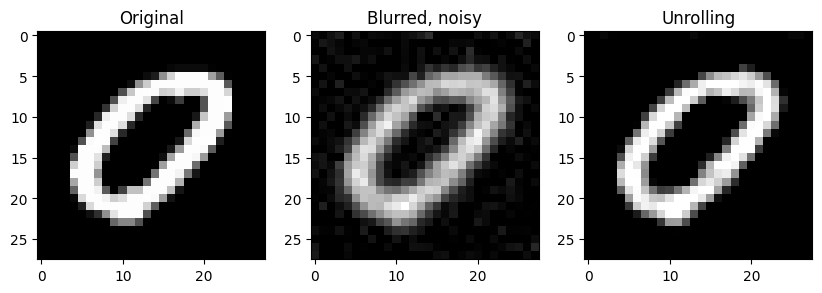

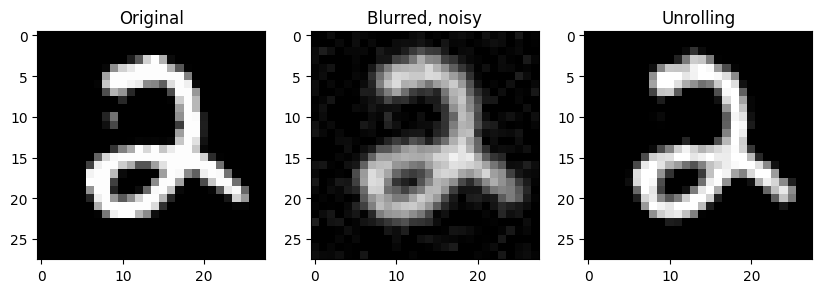

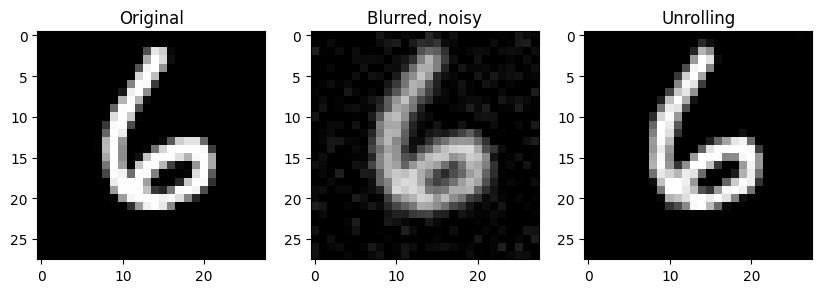

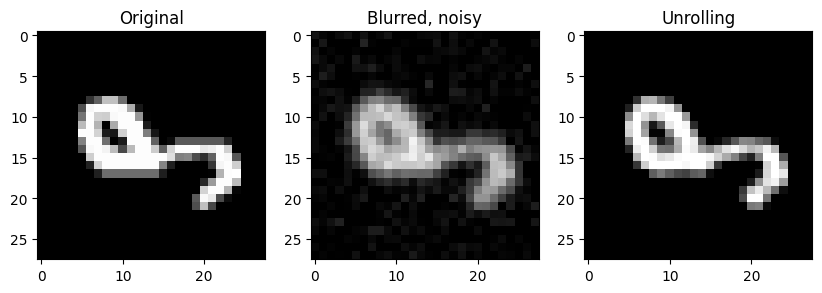

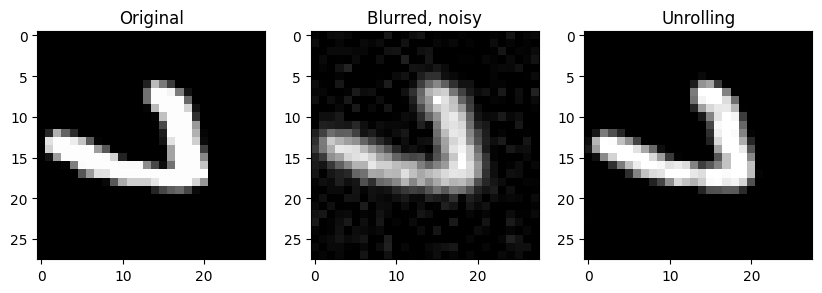

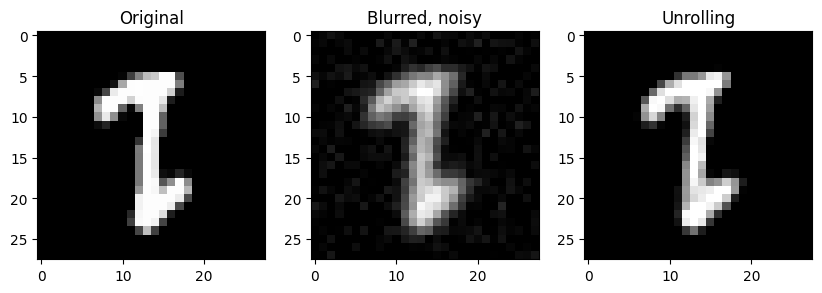

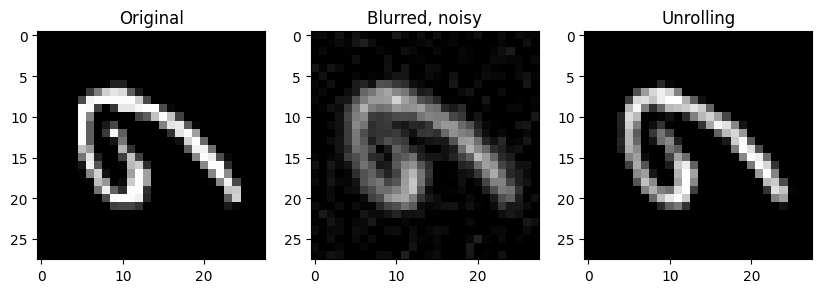

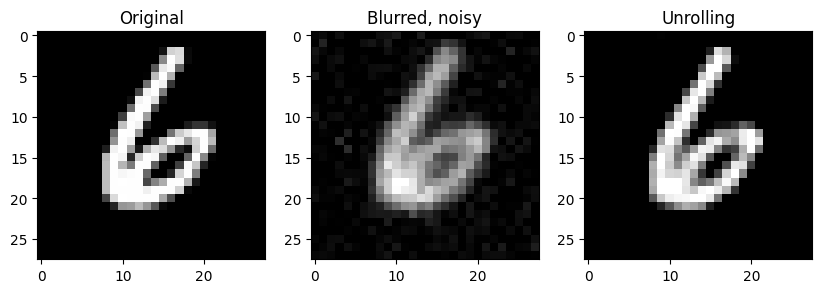

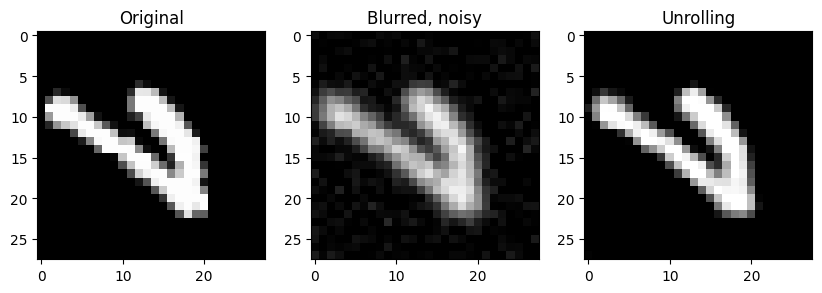

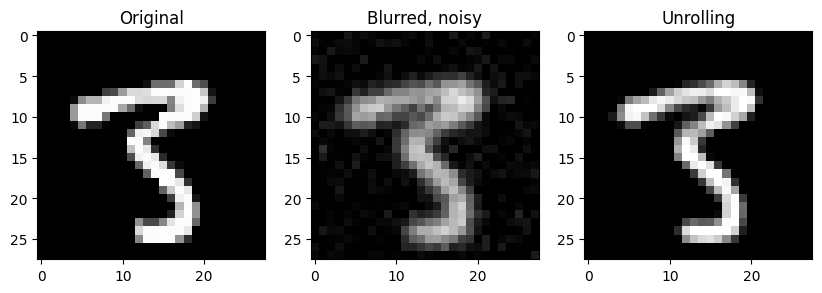

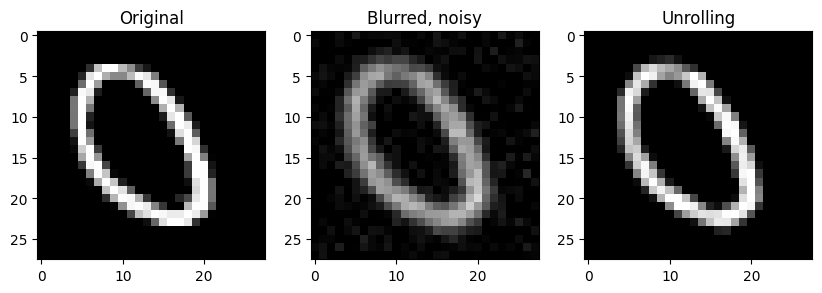

In [ ]:
#To test uncomment next lines
Net = Network(Initialization, train_conditions, paths)
Net.test(path_set=path_test, path_model="Models/Trained_Model_1/epoch99", need_names='yes')